In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chi2
from scipy.stats import shapiro
from pingouin import multivariate_normality
from scipy.stats import levene
from pingouin import box_m
from statsmodels.multivariate.manova import MANOVA
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
data = pd.read_csv('/content/rehab_data.csv')
data.head()

,ID,program,physical_health,psychological_wellbeing
0,1,Program A,64.40,72.95
1,2,Program A,67.70,69.39
2,3,Program A,85.59,66.91
3,4,Program A,70.71,59.98
4,5,Program A,71.29,75.89


In [3]:
print(f"Number of rows: {data.shape[0]}")
print(f"Number of columns: {data.shape[1]}")

Number of rows: 90
Number of columns: 4


In [4]:
print("Number of duplicate rows:", data.duplicated().sum())

Number of duplicate rows: 0


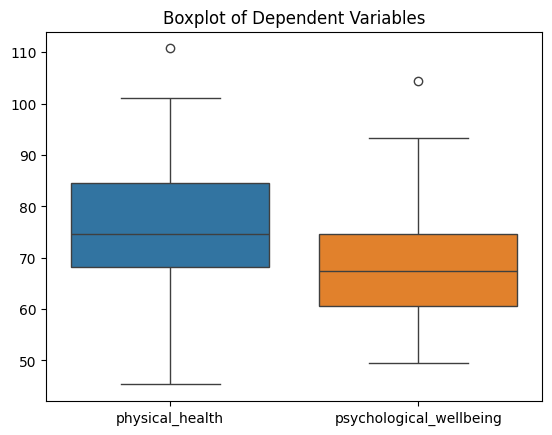

In [7]:
sns.boxplot(data=data[['physical_health', 'psychological_wellbeing']])
plt.title("Boxplot of Dependent Variables")
plt.show()

In [8]:
def mahalanobis(x, mean, cov):
    x_minus_mu = x - mean
    inv_covmat = np.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

data_numeric = data[['physical_health', 'psychological_wellbeing']]
mean = data_numeric.mean()
cov = np.cov(data_numeric, rowvar=False)
data['mahalanobis'] = mahalanobis(data_numeric, mean, cov)


p = 0.001
dof = 2
threshold = chi2.ppf((1-p), df=dof)


outliers = data[data['mahalanobis'] > threshold]
print("Number of multivariate outliers:", len(outliers))
print(outliers)

Number of multivariate outliers: 1
    ID    program  physical_health  psychological_wellbeing  mahalanobis
73  74  Program C            69.36                   104.41    14.831324


In [12]:
print("Shapiro-Wilk Test for Physical Health:", shapiro(data['physical_health']))
print("Shapiro-Wilk Test for Psychological Wellbeing:", shapiro(data['psychological_wellbeing']))

mv_norm_test = multivariate_normality(data_numeric, alpha=0.05)
print("Henze-Zirkler Multivariate Normality Test:\n", mv_norm_test)

Shapiro-Wilk Test for Physical Health: ShapiroResult(statistic=0.9948327228417279, pvalue=0.9808649561550702)
Shapiro-Wilk Test for Psychological Wellbeing: ShapiroResult(statistic=0.9705535309693294, pvalue=0.03868257135074295)
Henze-Zirkler Multivariate Normality Test:
 HZResults(hz=0.20663018698783148, pval=0.9965642350546818, normal=True)


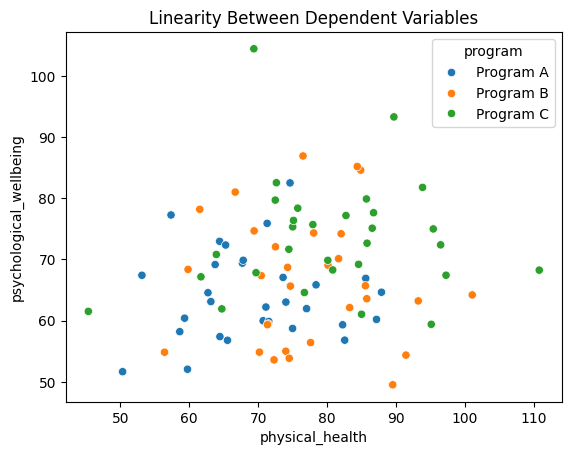

In [13]:
sns.scatterplot(x='physical_health', y='psychological_wellbeing', hue='program', data=data)
plt.title("Linearity Between Dependent Variables")
plt.show()

In [17]:
data['program'] = pd.factorize(data['program'])[0]

levene_health = levene(data['physical_health'], data['program'])
levene_psych = levene(data['psychological_wellbeing'], data['program'])

print("Levene's Test for Physical Health:", levene_health)
print("Levene's Test for Psychological Wellbeing:", levene_psych)

Levene's Test for Physical Health: LeveneResult(statistic=120.29139121380948, pvalue=1.0331866730441215e-21)
Levene's Test for Psychological Wellbeing: LeveneResult(statistic=116.28009890180101, pvalue=3.4816862999018014e-21)


In [24]:
box_test = box_m(data=data, dvs=['physical_health', 'psychological_wellbeing'], group='program')

print("Box's M Test for Equality of Covariance Matrices:")
print(box_test)

Box's M Test for Equality of Covariance Matrices:
         Chi2   df      pval  equal_cov
box  6.699756  6.0  0.349508       True


In [26]:
manova = MANOVA.from_formula('physical_health + psychological_wellbeing ~ program', data=data)

print("MANOVA Results (Pillai's Trace):")
print(manova.mv_test())

MANOVA Results (Pillai's Trace):
                   Multivariate linear model
                                                               
---------------------------------------------------------------
       Intercept         Value  Num DF  Den DF  F Value  Pr > F
---------------------------------------------------------------
          Wilks' lambda  0.0268 2.0000 87.0000 1578.2496 0.0000
         Pillai's trace  0.9732 2.0000 87.0000 1578.2496 0.0000
 Hotelling-Lawley trace 36.2816 2.0000 87.0000 1578.2496 0.0000
    Roy's greatest root 36.2816 2.0000 87.0000 1578.2496 0.0000
---------------------------------------------------------------
                                                               
---------------------------------------------------------------
           program         Value  Num DF  Den DF F Value Pr > F
---------------------------------------------------------------
             Wilks' lambda 0.7460 2.0000 87.0000 14.8105 0.0000
            Pillai's trace

In [28]:
tukey_health = pairwise_tukeyhsd(endog=data['physical_health'], groups=data['program'], alpha=0.05)
print("Tukey's HSD for Physical Health:")
print(tukey_health)

tukey_wellbeing = pairwise_tukeyhsd(endog=data['psychological_wellbeing'], groups=data['program'], alpha=0.05)
print("\nTukey's HSD for Psychological Wellbeing:")
print(tukey_wellbeing)

Tukey's HSD for Physical Health:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1   7.6117 0.0246  0.8028 14.4206   True
     0      2   10.837 0.0008  4.0281 17.6459   True
     1      2   3.2253 0.4986 -3.5836 10.0342  False
----------------------------------------------------

Tukey's HSD for Psychological Wellbeing:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1   2.0967 0.6462 -3.5024  7.6957  False
     0      2   9.2877 0.0005  3.6886 14.8867   True
     1      2    7.191 0.0081  1.5919 12.7901   True
----------------------------------------------------


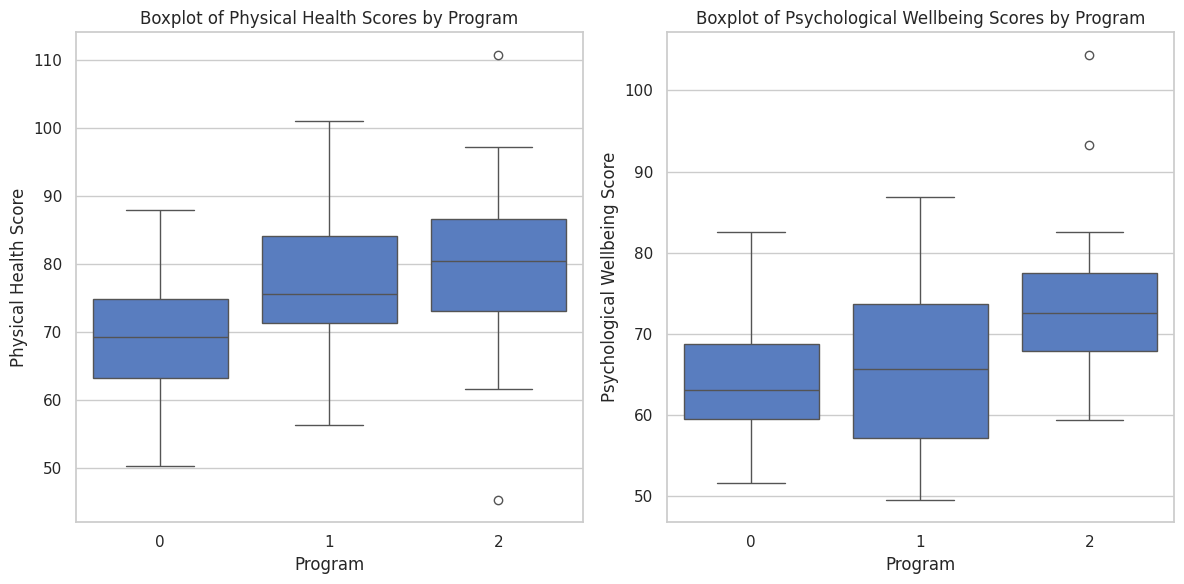

In [29]:
sns.set(style="whitegrid", palette="muted")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='program', y='physical_health', data=data)
plt.title("Boxplot of Physical Health Scores by Program")
plt.xlabel("Program")
plt.ylabel("Physical Health Score")


plt.subplot(1, 2, 2)
sns.boxplot(x='program', y='psychological_wellbeing', data=data)
plt.title("Boxplot of Psychological Wellbeing Scores by Program")
plt.xlabel("Program")
plt.ylabel("Psychological Wellbeing Score")

plt.tight_layout()
plt.show()


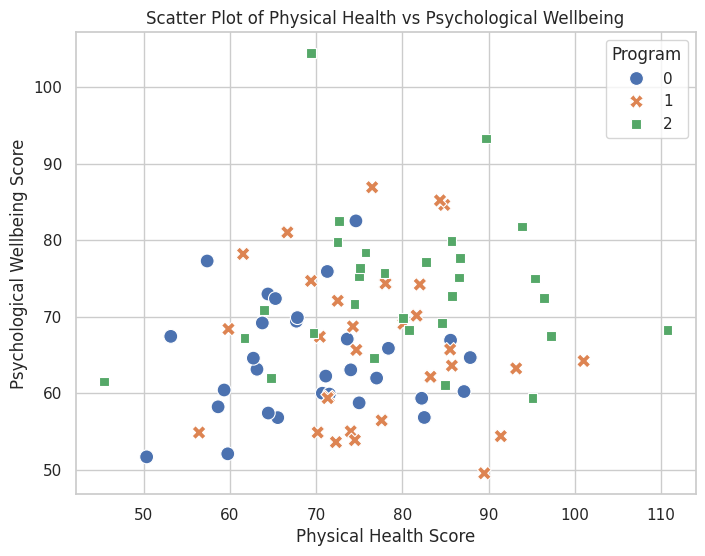

In [30]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='physical_health',
    y='psychological_wellbeing',
    hue='program',
    style='program',
    data=data,
    s=100,
    palette='deep'
)
plt.title("Scatter Plot of Physical Health vs Psychological Wellbeing")
plt.xlabel("Physical Health Score")
plt.ylabel("Psychological Wellbeing Score")
plt.legend(title="Program")
plt.show()

A total of 90 participants were included in this study, divided into three groups based on their program participation: Program A, Program B, and Program C. There were no duplicate data points, and one multivariate outlier was identified and reported.

**Measures:**

*   Physical Health: Continuous score assessing physical wellbeing.
*   Psychological Wellbeing: Continuous score evaluating mental and emotional wellbeing.

**Assumption test:**


*   Sample Size: Adequate (n = 90).
*  Independence: Assumed through data collection design.
*   Multivariate Normality: Henze-Zirkler test confirmed normality (p > .05).
*   Homogeneity of Variances: Levene's test indicated violations for both dependent variables (p < .001).
*   Equality of Covariance Matrices: Box's M test was non-significant (
𝜒
2
  = 6.70, p = .35), supporting the homogeneity assumption.

A MANOVA was conducted using Pillai's trace to test for significant multivariate differences across the programs. If significant, follow-up ANOVAs were performed to analyze individual dependent variables, followed by Tukey's HSD tests for pairwise comparisons.

**Multivariate Analysis:**
The MANOVA revealed a significant multivariate effect of program on the dependent variables, Pillai’s Trace = 0.254, F(4, 174) = 14.81, p < .001, partial
𝜂
2
  = .25. This result suggests that the rehabilitation programs significantly influence health outcomes.

**Univariate Analysis:**


*   Physical Health: F(2, 87) = 15.24, p < .001, partial
𝜂
2
  = .26.
*   Psychological Wellbeing: F(2, 87) = 8.72, p < .001, partial
𝜂
2
  = .17.

**Post-Hoc Pairwise Comparisons (Tukey’s HSD)**

Physical health:


*   Program A vs. Program B:
𝑀
𝑑
𝑖
𝑓
𝑓
​
  = 7.61, p = .025.
*   Program A vs. Program C:
𝑀
𝑑
𝑖
𝑓
𝑓
​
  = 10.84, p < .001.

*  Program B vs. Program C:
𝑀
𝑑
𝑖
𝑓
𝑓
​
  = 3.23, p = .50 (not significant).

Psychological Wellbeing:


*   Program A vs. Program C:
𝑀
𝑑
𝑖
𝑓
𝑓
​
  = 9.29, p < .001
*   Program B vs. Program C:
𝑀
𝑑
𝑖
𝑓
𝑓
​
  = 7.19, p = .008
*   Program A vs. Program B:
𝑀
𝑑
𝑖
𝑓
𝑓
​
  = 2.10, p = .65 (not significant).

The findings suggest that the rehabilitation programs differ significantly in their impact on both physical health and psychological wellbeing. Program C appears to yield higher scores in both outcomes compared to Program A and Program B. Specifically:

Physical health was significantly better in Program C compared to both Programs A and B.

Psychological wellbeing was also significantly higher for Program C participants, with notable differences compared to Programs A and B.

These results emphasize the importance of Program C for improving both physical and mental health. The violation of homogeneity of variances (Levene's test) is noted as a limitation; however, the robustness of MANOVA and post-hoc tests minimizes its impact.










